In [1]:
from wordpress_graph.paths import DATA_DIR
import feedparser
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
xml_files = list(DATA_DIR.glob('xml/*.xml'))

In [3]:
post_df = pd.DataFrame(columns = ['title', 'tags', 'category', 'link', 'date'])

for xml_file in xml_files:
    # parse file
    d = feedparser.parse(xml_file)
    # unique entry types
    print(np.unique([i.wp_post_type for i in d.entries]))
    
    # go through entries
    for entry in tqdm(d.entries):
        # only interested in posts
        if entry.wp_post_type == 'post':
            if entry.wp_status == 'publish':
                title = entry.title
                tags = [tag.term for tag in entry.tags if tag.scheme == 'post_tag']
                category = [tag.term for tag in entry.tags if tag.scheme == 'category'][0]
                link = entry.link
                publish_date = entry.published_parsed
                post_df.loc[len(post_df)] = [title, tags, category, link, publish_date]

['attachment' 'nav_menu_item' 'post']



['attachment' 'post']


In [4]:
post_df['slug'] = [i.lower().replace(" ", "_") for i in post_df.title.values]

In [5]:
post_df[:3]

,title,tags,category,link,date,slug
0,Critical Behavior from Deep Dynamics: A Hidden...,"[Language, LSTM, Markov]",Papers,https://timsainburg.wordpress.com/2016/08/05/c...,"(2016, 8, 5, 2, 33, 37, 4, 218, 0)",critical_behavior_from_deep_dynamics:_a_hidden...
1,Adversarially Learned Inference,[GAN],Papers,https://timsainburg.wordpress.com/2016/08/05/a...,"(2016, 8, 5, 2, 58, 40, 4, 218, 0)",adversarially_learned_inference
2,InfoGAN: Interpretable Representation Learning...,[GAN],Papers,https://timsainburg.wordpress.com/2016/08/05/i...,"(2016, 8, 5, 3, 1, 20, 4, 218, 0)",infogan:_interpretable_representation_learning...


In [58]:
all_tags = np.concatenate(post_df.tags.values)
len(all_tags)

1943

#### tag info

In [59]:
# get tag freqiemcoes
tag_df = pd.DataFrame([[i, np.sum(all_tags == i)] for i in np.unique(all_tags)], columns = ['tag', 'frequency'])

In [82]:
display(tag_df.sort_values(by="frequency", ascending=False)[:10])
fig, ax = plt.subplots(figsize=(6,2))
ax.hist(tag_df.frequency, bins=50);

,tag,frequency
540,syntax,80
10,Birdsong,70
298,hierarchy,61
52,Language,46
53,Language Acquisition,36
494,sequence learning,31
86,Recursion,28
62,Markov Models,27
595,zebra finch,24
578,vocalization,23


In [148]:
len(np.unique(np.concatenate(post_df.tags.values)))

597

#### Subset only papers

In [175]:
post_df.category.unique()

array(['Papers'], dtype=object)

In [176]:
post_df = post_df[post_df.category == 'Papers']

In [177]:
len(post_df)

417

### Make a graph
- the value of edges should be weighted by frequency of the overlapping tag

In [178]:
import networkx as nx

In [179]:
G=nx.Graph()
filtered_entries = []

In [180]:
# add nodes to graph
for idx, row in post_df.iterrows():
    G.add_node(row.slug, type = row.category)

In [184]:
all_weights = []
overlapping_tags = []
# get weight as # of similar tags between two posts
for idx, row in tqdm(post_df.iterrows(), total = len(post_df)):
    for idx2, row2 in post_df.iterrows():
        if row.title != row2.title:
            overlap = [tag for tag in row.tags if tag in row2.tags]
            if len(overlap) > 0:
                # weight tags by frequency
                weights = [1/np.log(tag_df[tag_df.tag == tag].frequency.values[0]) for tag in overlap]
                weight = np.sum(weights)
                all_weights.append(weight)
                # add edge
                if weight > 0:
                    overlapping_tags.append(overlap)
                    G.add_edge(row.slug, row2.slug, weight=weight)

In [185]:
len(G.edges()), len(G.nodes())

(11161, 414)

In [186]:
# remove nodes that aren't connected to anything
num_conns = pd.DataFrame(columns=['node', 'conns'])
# remove nodes that have no connections
for node in list(G.nodes().keys()):
    if G.degree(node) == 0:
        G.remove_node(node)
    else:
        num_conns.loc[len(num_conns)] = [node, G.degree(node)]

In [187]:
num_conns.sort_values(by="conns", ascending=False)[:5]

,node,conns
333,experimental_evidence_for_compositional_syntax...,189
62,songbirds_possess_the_spontaneous_ability_to_d...,169
350,experimental_evidence_for_phonemic_contrasts_i...,168
205,biological_foundations_and_origins_of_syntax,167
102,songs_to_syntax:_the_linguistics_of_birdsong,165


In [188]:
len(G.edges()), len(G.nodes())

(11161, 401)

In [189]:
weights = np.array([i['weight'] for i in list(G.edges().values())])

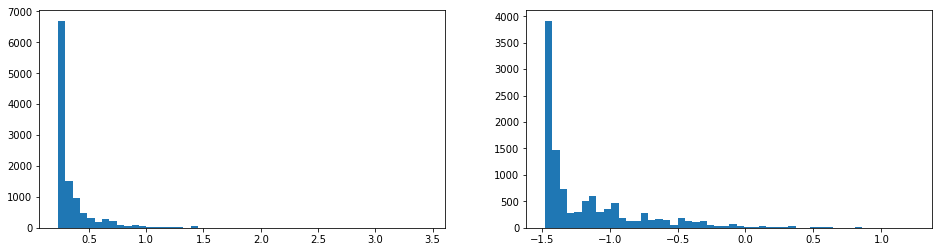

In [190]:
fig, axs = plt.subplots(ncols=2, figsize=(16,4))
axs[0].hist(weights, bins=50);
axs[1].hist(np.log(weights), bins=50);

In [197]:
#pos = nx.spring_layout(G)
spring_pos = nx.spring_layout(G, k=1/len(G.nodes())**.25)

(-0.806440738772257, 0.806440738772257)

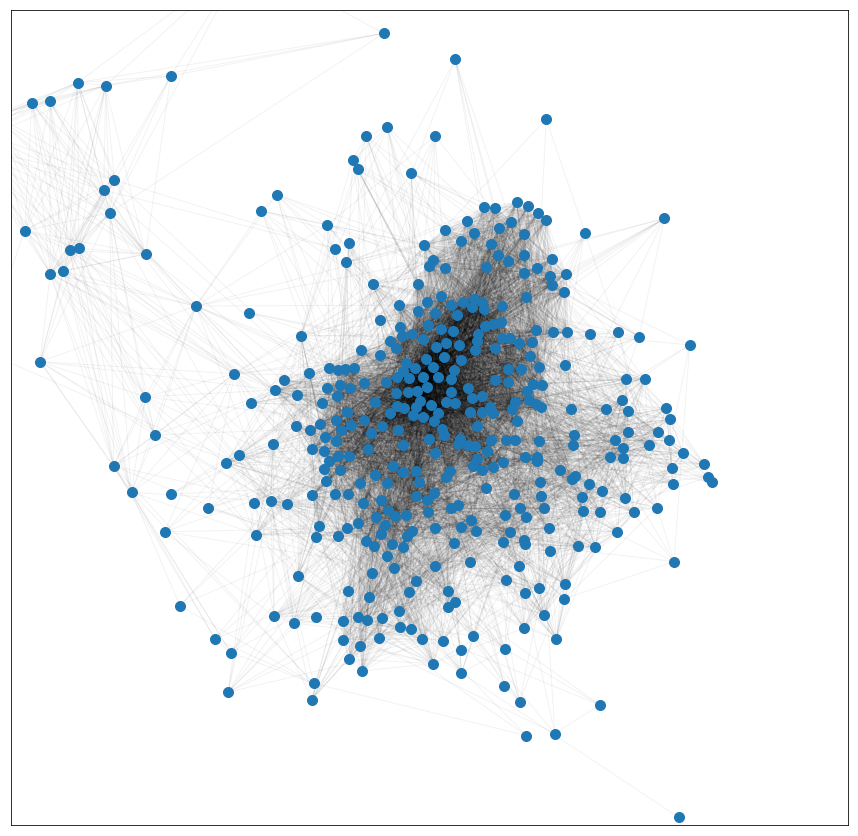

In [200]:
pos = spring_pos
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,15))
nx.draw_networkx_edges(G, pos = pos, alpha = 0.05)
nx.draw_networkx_nodes(G, pos = pos, alpha = 1, node_size=100)

nstd= 3
pos_array = np.vstack(spring_pos.values())
pos_mean = np.mean(pos_array, axis=0)
pos_std = np.std(pos_array, axis=0)

ax.set_xlim([pos_mean[0]-pos_std[0]*3, pos_mean[0]+pos_std[0]*3])
ax.set_ylim([pos_mean[1]-pos_std[1]*3, pos_mean[1]+pos_std[1]*3])

In [201]:
kamada_kawai_pos = nx.drawing.layout.kamada_kawai_layout(G)

(-0.806440738772257, 0.806440738772257)

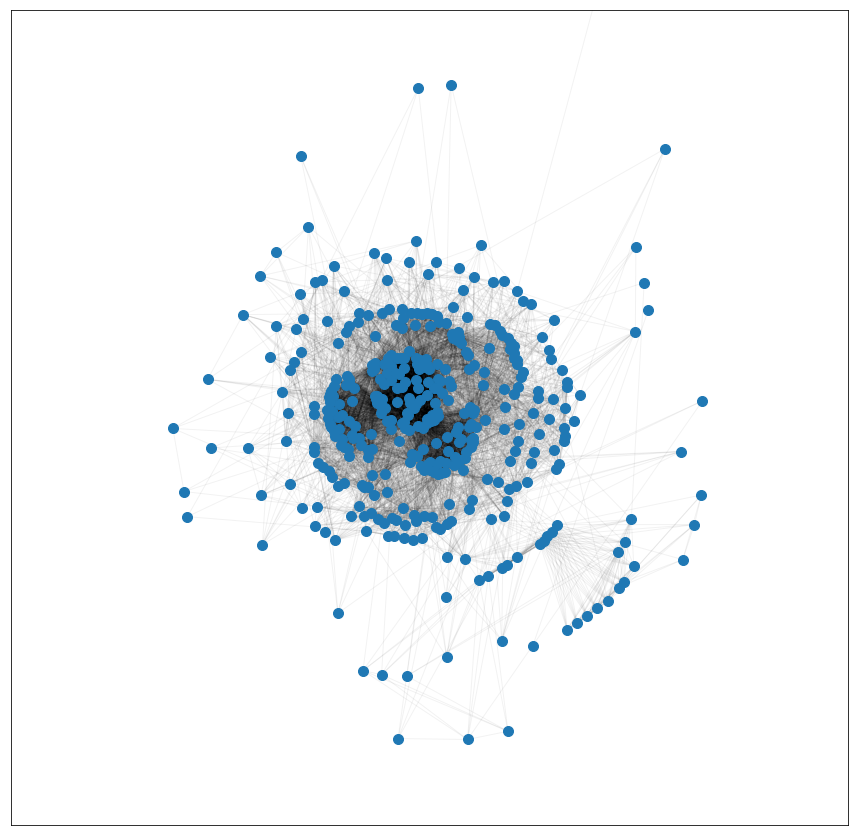

In [204]:
pos = kamada_kawai_pos
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,15))
nx.draw_networkx_edges(G, pos = pos, alpha = 0.05)
nx.draw_networkx_nodes(G, pos = pos, alpha = 1, node_size=100)

nstd= 2
pos_array = np.vstack(spring_pos.values())
pos_mean = np.mean(pos_array, axis=0)
pos_std = np.std(pos_array, axis=0)

ax.set_xlim([pos_mean[0]-pos_std[0]*3, pos_mean[0]+pos_std[0]*3])
ax.set_ylim([pos_mean[1]-pos_std[1]*3, pos_mean[1]+pos_std[1]*3])

### Cluster communiities

In [205]:
import community
import seaborn as sns

In [206]:
partition = community.best_partition(G)
set(partition.values())

{0, 1, 2, 3, 4, 5, 6, 7}

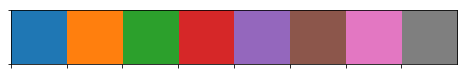

In [212]:
pal = sns.color_palette("tab10", n_colors=len(set(partition.values())))
sns.palplot(pal)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

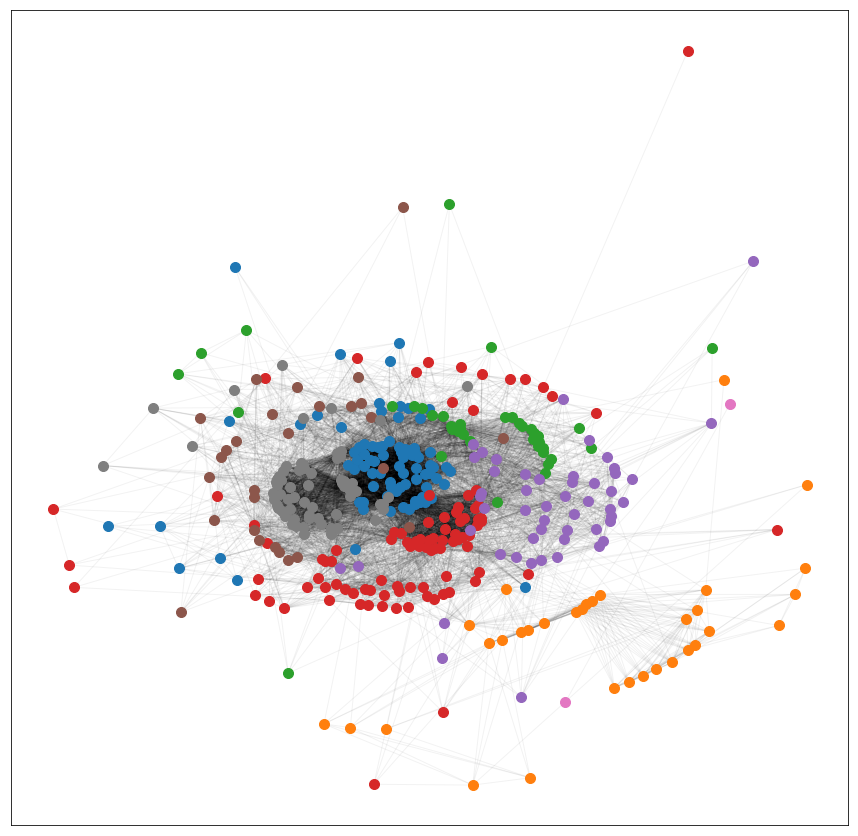

In [216]:
pos = kamada_kawai_pos
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,15))
for count, com in enumerate(set(partition.values()) ):
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 100,
                                node_color = list(pal[count]))


nx.draw_networkx_edges(G, pos, alpha=0.05)

nstd= 2
pos_array = np.vstack(pos.values())
pos_mean = np.mean(pos_array, axis=0)
pos_std = np.std(pos_array, axis=0)

plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

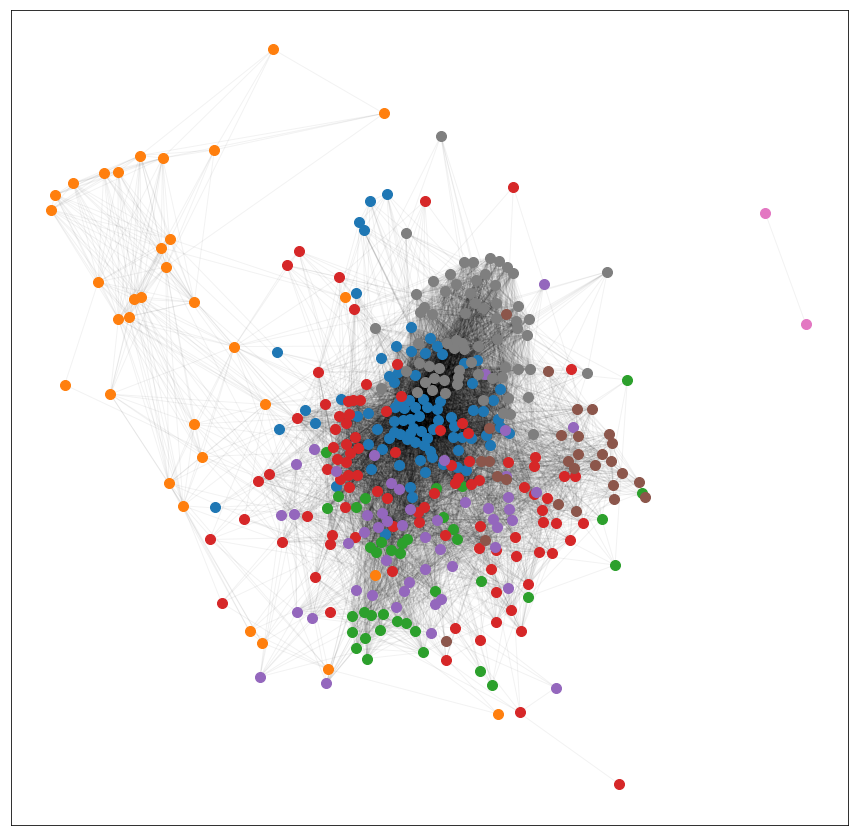

In [217]:
pos = spring_pos
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,15))
for count, com in enumerate(set(partition.values()) ):
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 100,
                                node_color = list(pal[count]))


nx.draw_networkx_edges(G, pos, alpha=0.05)

nstd= 2
pos_array = np.vstack(pos.values())
pos_mean = np.mean(pos_array, axis=0)
pos_std = np.std(pos_array, axis=0)

plt.show()